In [2]:
import pandas as pd 
import warnings
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from tensorflow import keras 
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
warnings.filterwarnings("ignore")

In [3]:
# Loading the dataset
import tensorflow as tf
from tensorflow.keras import layers
seed = 123

train_dir = '/kaggle/input/dogs-vs-cats/train'
validation_dir = '/kaggle/input/dogs-vs-cats/test'

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels="inferred",
    label_mode="categorical", 
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.5,
    subset="training",
    seed=seed
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory=validation_dir,
    labels="inferred",
    label_mode="categorical", 
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=seed
)

Found 20000 files belonging to 2 classes.
Using 10000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.


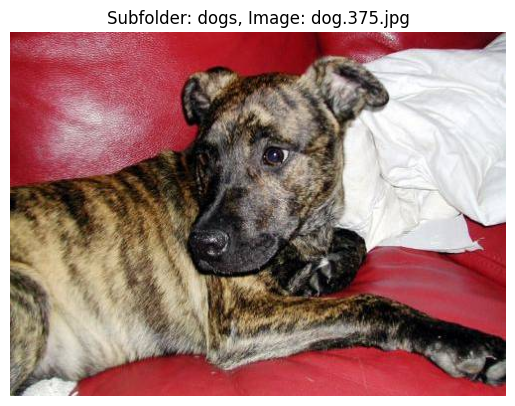

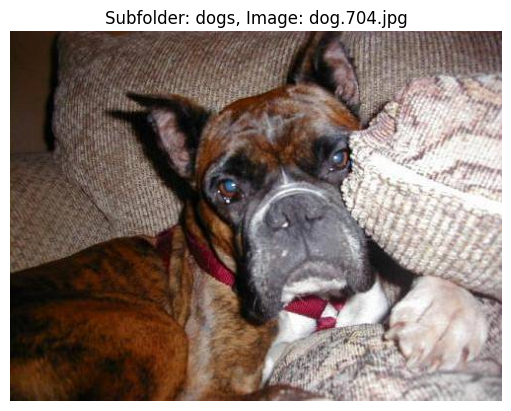

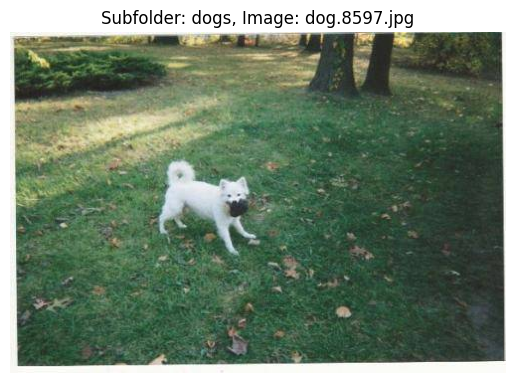

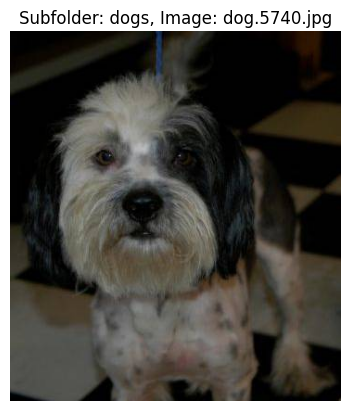

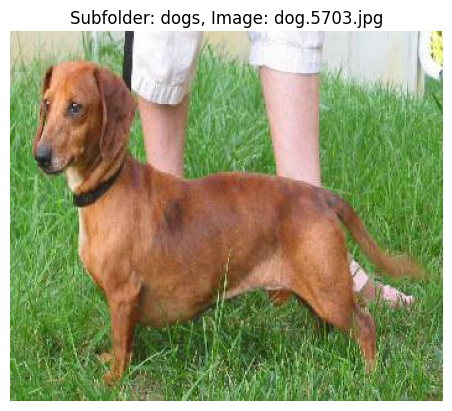

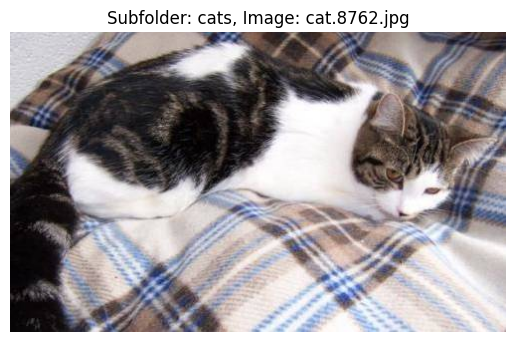

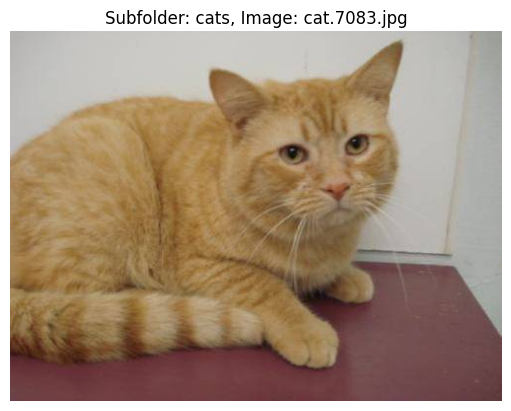

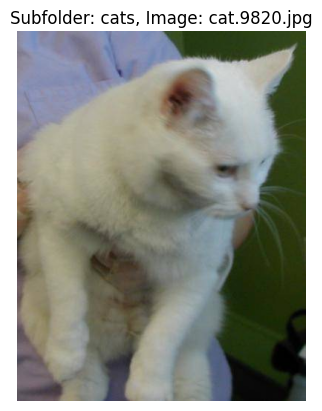

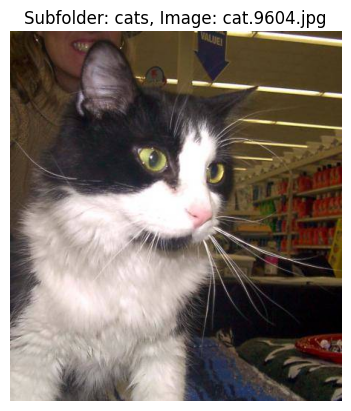

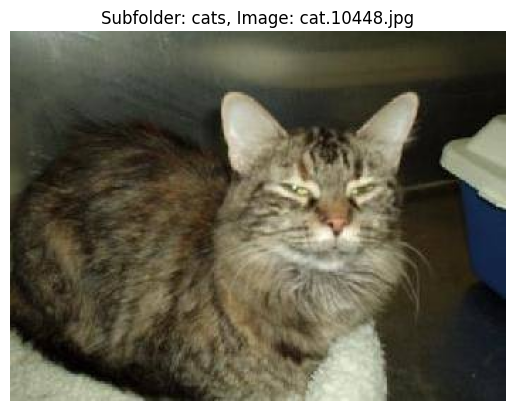

In [4]:
# For visualizing
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

main_folder = '/kaggle/input/dogs-vs-cats/test'

for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        for image_file in os.listdir(subfolder_path)[:5]:
            image_path = os.path.join(subfolder_path, image_file)
            image = mpimg.imread(image_path)
            plt.imshow(image)
            plt.title(f'Subfolder: {subfolder}, Image: {image_file}')
            plt.axis('off')
            plt.show()

In [5]:
#for normalization
def process(image,label):
    image = tf.cast(image/255,tf.float32)
    return image,label
train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [6]:
#Model training
from tensorflow.keras.applications import VGG16 ,Xception

conv_base = Xception(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3),
    pooling='avg'
)
conv_base.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
model = Sequential()
model.add(conv_base)
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.35))
model.add(BatchNormalization())
model.add(Dense(120, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [8]:
# Compiling the model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
history = model.fit(train_ds, epochs=10, validation_data=validation_ds,callbacks=[EarlyStopping(patience=0)])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1619s 5s/step - accuracy: 0.9661 - loss: 0.0883 - val_accuracy: 0.9860 - val_loss: 0.0436
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1574s 5s/step - accuracy: 0.9877 - loss: 0.0315 - val_accuracy: 0.9860 - val_loss: 0.0468


In [9]:
# Evaulating the model
validation_loss, validation_accuracy = model.evaluate(validation_ds)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)


32/32 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.9876 - loss: 0.0369
Validation Loss: 0.04682604968547821
Validation Accuracy: 0.9860000014305115


In [11]:
# Testing the model by using the test data that was not used earlier
test_dir = '/kaggle/input/dogs-vs-cats/test'

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    seed=seed
)

Found 5000 files belonging to 2 classes.


In [12]:
test_ds = test_ds.map(process)

In [13]:
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 725s 5s/step


In [14]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
true_labels = np.argmax(true_labels, axis=1)

Classification Report:
              precision    recall  f1-score   support

         Cat       0.49      0.50      0.50      2500
         Dog       0.49      0.49      0.49      2500

    accuracy                           0.49      5000
   macro avg       0.49      0.49      0.49      5000
weighted avg       0.49      0.49      0.49      5000



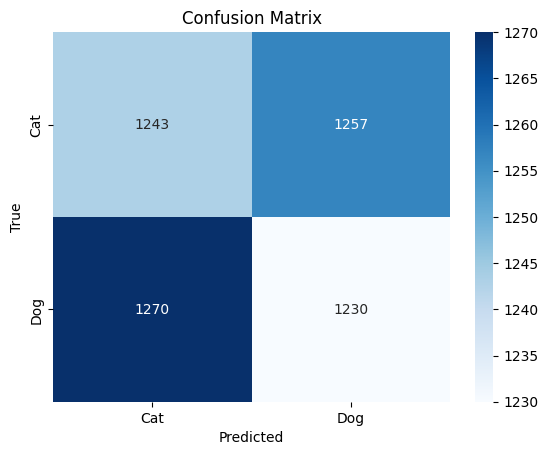

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Cat", "Dog"]))
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.4946
